In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.decomposition import PCA
import torch.nn.functional as F
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from fastai.learner import Learner
from fastai.losses  import MSELossFlat
from fastai.collab import *
from fastai.metrics import error_rate
from fastai.tabular.model import get_emb_sz
%matplotlib inline

In [ ]:
path_ratings = '/content/drive/MyDrive/DATA/MovieLensSmall/ratings.csv'
path_movies = '/content/drive/MyDrive/DATA/MovieLensSmall/movies.csv'

In [ ]:
ratings_df = pd.read_csv(f'{path_ratings}', low_memory=False)
movies_df = pd.read_csv(f'{path_movies}', low_memory=False)

In [ ]:
display(ratings_df, movies_df)

In [ ]:
ratings_movies = ratings_df.merge(movies_df)
ratings_movies

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [ ]:
# dls = torch.utils.data.DataLoader(batch_size = 64, dataset=ratings_movies[['userId', 'rating', 'title']])

In [ ]:
!pip install fastai  -U

In [ ]:
dls = CollabDataLoaders.from_df(ratings = ratings_movies, item_name='title', user_name = 'userId', bs=64, seed=42, rating_name='rating')

In [ ]:
dls.show_batch()

,userId,title,rating
0,160,Toy Story (1995),4.0
1,590,Shanghai Noon (2000),3.0
2,111,Fast Times at Ridgemont High (1982),2.0
3,160,Empire Records (1995),3.0
4,555,Cat People (1982),3.0
5,528,Stranger in the House (1997),4.5
6,132,Singles (1992),2.0
7,600,Kicking and Screaming (1995),1.0
8,428,Dances with Wolves (1990),2.0
9,599,Let Me In (2010),3.5


In [ ]:
def create_params(size):
    return torch.nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [ ]:
#  A class defining our dot product model
class DotProduct(torch.nn.Module):
  
  def __init__(self, n_users, n_movies, n_factors, y_scale):
    super().__init__()
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_scale = y_scale

  def sigmoid_scale(self, x, floor, ceil):
    return torch.sigmoid(x) * (ceil - floor) + floor

  def forward(self, x):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users * movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return self.sigmoid_scale((users * movies).sum(dim=1), *self.y_scale)


In [ ]:
n_users  = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])

In [ ]:
model = DotProduct(n_users, n_movies, n_factors = 50, y_scale=(0, 5.5))
learner1 = Learner(dls, model, loss_func= MSELossFlat())

In [ ]:
learner1.fit_one_cycle(5, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.467452,1.408332,00:17
1,0.884777,0.877418,00:21
2,0.801310,0.821104,00:11
3,0.706217,0.805664,00:11
4,0.666895,0.804004,00:11


SuggestedLRs(valley=0.00013182566908653826)

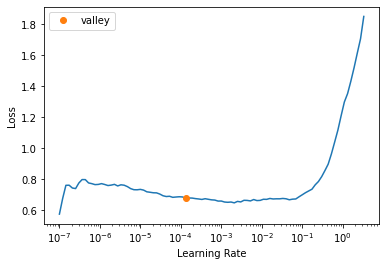

In [ ]:
learner1.lr_find()

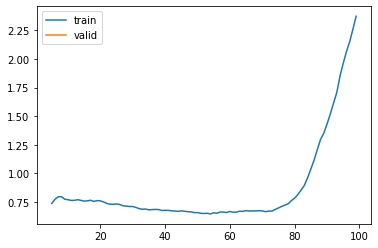

In [ ]:
learner1.recorder.plot_loss()

In [ ]:
learner1.fit_one_cycle(5, 1e-4, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.678812,0.802224,00:11
1,0.704463,0.798521,00:11
2,0.697423,0.795676,00:11
3,0.678362,0.794585,00:11
4,0.663100,0.794345,00:11


## Interpreting Embeddings and Biases

In [ ]:
movie_bias = learner1.model.movie_bias

In [ ]:
movie_bias.shape

torch.Size([9720])

In [ ]:
idxs = movie_bias.argsort()[:10]

In [ ]:
[dls.classes['title'][i] for i in idxs]

['Four Weddings and a Funeral (1994)',
 'Spectre (2015)',
 'Last King of Scotland, The (2006)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'World of Glory (1991)',
 'Bubble Boy (2001)',
 'Legend of Sleepy Hollow, The (1949)',
 'Hide and Seek (2005)',
 'Two if by Sea (1996)',
 'River, The (1984)']

In [ ]:
idxs = movie_bias.argsort(descending=True)[:10]
[dls.classes['title'][i] for i in idxs]

['The Revenant (2015)',
 'Prime Suspect: The Lost Child (1995)',
 'Purge, The (2013)',
 'Treasure of the Sierra Madre, The (1948)',
 'El Cid (1961)',
 'Three Men and a Baby (1987)',
 'Rocky II (1979)',
 'Mr. Baseball (1992)',
 'Girl 6 (1996)',
 'Nine Months (1995)']

In [ ]:
g = ratings_movies.groupby('title')['rating'].count()

In [ ]:
top_movies = g.sort_values(ascending=False).index.values[:1000];
top_movies

array(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Jurassic Park (1993)', 'Braveheart (1995)',
       'Terminator 2: Judgment Day (1991)', "Schindler's List (1993)",
       'Fight Club (1999)', 'Toy Story (1995)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Usual Suspects, The (1995)', 'American Beauty (1999)',
       'Seven (a.k.a. Se7en) (1995)',
       'Independence Day (a.k.a. ID4) (1996)', 'Apollo 13 (1995)',
       'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
       'Lord of the Rings: The Fellowship of the Ring, The (2001)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Godfather, The (1972)', 'Fugitive, The (1993)', 'Batman (1989)',
       'Saving Private Ryan (1998)',
       'Lord of the Rings: The Two Towers, The (2002)',
       '

In [ ]:
title_list = dls.classes['title'];
title_list

['#na#', "'71 (2014)", "'Hellboy': The Seeds of Creation (2004)", "'Round Midnight (1986)", "'Salem's Lot (2004)", "'Til There Was You (1997)", "'Tis the Season for Love (2015)", "'burbs, The (1989)", "'night Mother (1986)", '(500) Days of Summer (2009)', '*batteries not included (1987)', '...All the Marbles (1981)', '...And Justice for All (1979)', '00 Schneider - Jagd auf Nihil Baxter (1994)', '1-900 (06) (1994)', '10 (1979)', '10 Cent Pistol (2015)', '10 Cloverfield Lane (2016)', '10 Items or Less (2006)', '10 Things I Hate About You (1999)', '10 Years (2011)', '10,000 BC (2008)', '100 Girls (2000)', '100 Streets (2016)', '101 Dalmatians (1996)', '101 Dalmatians (One Hundred and One Dalmatians) (1961)', "101 Dalmatians II: Patch's London Adventure (2003)", '101 Reykjavik (101 Reykjavík) (2000)', '102 Dalmatians (2000)', '10th & Wolf (2006)', '10th Kingdom, The (2000)', '10th Victim, The (La decima vittima) (1965)', '11\'09"01 - September 11 (2002)', '11:14 (2003)', '11th Hour, The (

In [ ]:
def val2idx(x):
    "Dict from value to index"
    return {v:k for k,v in enumerate(x)}

In [ ]:
a = val2idx(title_list)

In [ ]:
top_index = torch.tensor([a[m] for m in top_movies])

In [ ]:
movie_w = learner1.model.movie_factors[top_index].cpu().detach()

In [ ]:
pca = PCA(4)
pca.fit(movie_w.numpy())

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
fac0, fac1, fac2, fac3 = pca.components_

In [ ]:
fac0, fac1, fac1, fac3 = map(torch.tensor, (fac0, fac1, fac1, fac3))

In [ ]:
fac0.type()

'torch.FloatTensor'

In [ ]:
movie_factors_pac = [(fac, i) for fac, i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_factors_pac, reverse=True)[:10]

[(tensor(0.1639), 'Lord of the Rings: The Two Towers, The (2002)'),
 (tensor(0.1601), 'Godfather, The (1972)'),
 (tensor(0.1507), 'Speed (1994)'),
 (tensor(0.1500), 'Forrest Gump (1994)'),
 (tensor(0.1461), 'Matrix, The (1999)'),
 (tensor(0.1437), 'Die Hard (1988)'),
 (tensor(0.1420), 'Sixth Sense, The (1999)'),
 (tensor(0.1414), 'Dark Knight, The (2008)'),
 (tensor(0.1388), 'Dances with Wolves (1990)'),
 (tensor(0.1331), 'Terminator 2: Judgment Day (1991)')]

In [ ]:
movie_factors_pac = [(fac, i) for fac, i in zip(fac1, top_movies)]
sorted(movie_factors_pac, reverse=True)[:10]

[(tensor(0.5459), 'Lord of the Rings: The Two Towers, The (2002)'),
 (tensor(0.1606), 'Ace Ventura: Pet Detective (1994)'),
 (tensor(0.1449), 'True Lies (1994)'),
 (tensor(0.1314), 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (tensor(0.1296), 'Terminator 2: Judgment Day (1991)'),
 (tensor(0.1293), 'Pulp Fiction (1994)'),
 (tensor(0.1267), 'Star Wars: Episode IV - A New Hope (1977)'),
 (tensor(0.1258), 'Silence of the Lambs, The (1991)'),
 (tensor(0.0961), 'Saving Private Ryan (1998)'),
 (tensor(0.0943), 'Independence Day (a.k.a. ID4) (1996)')]

In [ ]:
movie_factors_pac = [(fac, i) for fac, i in zip(fac2, top_movies)]
sorted(movie_factors_pac, reverse=True)[:10]

[(0.5701881, "Schindler's List (1993)"),
 (0.42209026, 'Fugitive, The (1993)'),
 (0.1890765, 'Godfather, The (1972)'),
 (0.17859258, 'Terminator 2: Judgment Day (1991)'),
 (0.13714518, 'Usual Suspects, The (1995)'),
 (0.11185043, 'Lion King, The (1994)'),
 (0.07518502, 'Ace Ventura: Pet Detective (1994)'),
 (0.073550776, 'Die Hard (1988)'),
 (0.066230774, 'Beauty and the Beast (1991)'),
 (0.06572962, 'True Lies (1994)')]

In [ ]:
movie_factors_pac = [(fac, i) for fac, i in zip(fac3, top_movies)]
sorted(movie_factors_pac, reverse=True)[:10]

[(tensor(0.3728), "Schindler's List (1993)"),
 (tensor(0.1575), 'Usual Suspects, The (1995)'),
 (tensor(0.1419), 'Terminator 2: Judgment Day (1991)'),
 (tensor(0.1352), 'Godfather, The (1972)'),
 (tensor(0.0673), 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (tensor(0.0536), 'Toy Story (1995)'),
 (tensor(0.0487), 'Ace Ventura: Pet Detective (1994)'),
 (tensor(0.0481), 'Mission: Impossible (1996)'),
 (tensor(0.0476), 'Back to the Future (1985)'),
 (tensor(0.0465), 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)')]

In [ ]:
movie_factors = learner1.model.movie_factors

In [ ]:
idx = dls.classes['title']
b = val2idx(idx)['Silence of the Lambs, The (1991)']

In [ ]:
dist = torch.nn.CosineSimilarity(dim=1)

In [ ]:
distances = dist(movie_factors, movie_factors[b].unsqueeze(0))

In [ ]:
id = distances.argsort(descending=True)[:3]

In [ ]:
dls.classes['title'][id]

(#3) ['Silence of the Lambs, The (1991)','In the Name of the Father (1993)','Shawshank Redemption, The (1994)']

In [ ]:
ems = get_emb_sz(dls);
ems

[(611, 58), (9720, 274)]

In [ ]:
class DeepNN(torch.nn.Module):

  def __init__(self, user_sz, item_sz, y_range=(0, 5.5), n_activation = 100):
    super().__init__()
    self.user_factors = torch.nn.Embedding(*user_sz)
    self.item_factors = torch.nn.Embedding(*item_sz)
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(user_sz[1]+item_sz[1], n_activation),
        torch.nn.ReLU(),
        torch.nn.Linear(n_activation, 1))
    self.y_scale = y_range

  def sigmoid_scale(self, x, floor, ceil):
    return torch.sigmoid(x) * (ceil - floor) + floor


  def forward(self, x):
    embeddings = self.user_factors(x[:, 0]), self.item_factors(x[:, 1])
    x = self.layers(torch.cat(embeddings, dim=1))
    return self.sigmoid_scale(x, *self.y_scale)

In [ ]:
model_NN = DeepNN(*ems)

In [ ]:
learner2 = Learner(dls, model_NN, loss_func=MSELossFlat())

In [ ]:
learner2.fit_one_cycle(5, wd = 0.01)

epoch,train_loss,valid_loss,time
0,0.898251,0.905078,00:13
1,0.778698,0.814450,00:13
2,0.698942,0.793730,00:13
3,0.668274,0.783625,00:13
4,0.623288,0.785346,00:13


SuggestedLRs(valley=0.0012022644514217973)

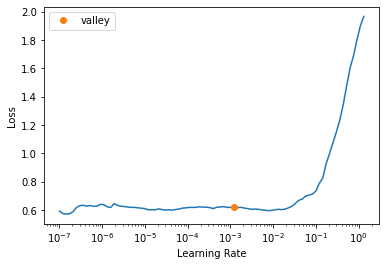

In [ ]:
learner2.lr_find()

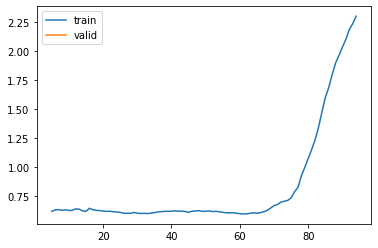

In [ ]:
learner2.recorder.plot_loss()

In [ ]:
learner2.fit_one_cycle(5, 1e-3, wd = 0.01)

epoch,train_loss,valid_loss,time
0,0.652174,0.816607,00:15
1,0.681091,0.802426,00:13
2,0.603588,0.812093,00:13
3,0.551670,0.815616,00:13
4,0.493432,0.821329,00:13


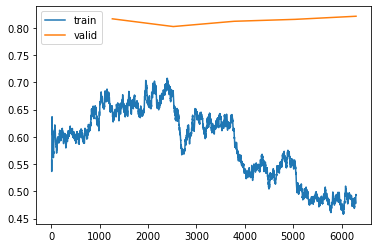

In [ ]:
learner2.recorder.plot_loss()

**UPDATING...**